# Satellite image generation (AWS data)

**Libraries needed:**

In [1]:
#---Cloud search libraries
import s3fs #---The installation of this package on conda makes me nervous for the environment stability
import requests
import fnmatch

#---Accessory libraries
import datetime
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as feature

**Set the datetime and band to view:**

In [2]:
year = 2024
month = 6
day = 29
hour = 6

band = '14' #---Include the leading zero, if needed

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

datetime_str = str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+' '+str(hour).zfill(2)+'Z'

181


**Select region for visualization:**

In [3]:
#--- Georges Bank (zoomed in)
# latitude_north = 42.5
# latitude_south = 37
# longitude_west = -71.5
# longitude_east = -64

#--- Georges Bank
# latitude_north = 46
# latitude_south = 33
# longitude_west = -73
# longitude_east = -57

#--- Oaxaca
# latitude_north = 24
# latitude_south = 8
# longitude_west = -109
# longitude_east = -81

#--- Global
# latitude_north = 90
# latitude_south = -90
# longitude_west = -360
# longitude_east = 0

#--- Gulf Stream
latitude_north = 51
latitude_south = 30
longitude_west = -80
longitude_east = -55

**Connecting to AWS remote storage:**

In [4]:
fs = s3fs.S3FileSystem(anon=True)

**Search the AWS database:**

In [5]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadF' #---Full disk ABI radiance

#---Add band selection here (C**)

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

files_band = [file for file in files if fnmatch.fnmatch(file.split('/')[-1], 'OR_ABI-L1b-RadF-M6C' + band + '*')]

In [6]:
file = files_band[0] #---first is the top-of-the-hour
print(file)

noaa-goes16/ABI-L1b-RadF/2024/181/06/OR_ABI-L1b-RadF-M6C14_G16_s20241810600212_e20241810609520_c20241810609566.nc


In [7]:
resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file[12:])
if str(resp) != '<Response [200]>':
    print('b07 file not found in AWS servers')

**Open the satellite data:**

In [8]:
nc = netCDF4.Dataset(file, memory = resp.content)
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))

**Get the latitudes and longitudes for the satellite image:**

In [9]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    #--- Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds



def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [10]:
ds_lat_lon = calc_latlon(ds)

#---This is needed to convert the lat/lon range into the x/y dimensions
#------The dataset will only filter by the official dimensions
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_lat_lon, (latitude_south, latitude_north), (longitude_west, longitude_east))

In [11]:
region = ds_lat_lon.sel(x=slice(x1, x2), y=slice(y2, y1))

In [12]:
region

<xarray.Dataset>
Dimensions:                                           (y: 769, x: 1143,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       number_of_harmonization_coefficients: 3,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float64 0.1286 ... ...
  * x                                                 (x) float64 -0.01308 .....
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
    lat                                               (y, x) float64 51.05 .....
    lon                                               (y, x) float64 -82.2 .....
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, number_of_harmonization_coefficients,
                                num_star_looks
Data variables: (12/39)
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2024-06-29T06:09:56.6Z
    time_coverage_start:       2024-06-29T06:00:21.2Z
    time_coverage_end:         2024-06-29T06:09:52.0Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevH_DO_13_00_00)-7...
    id:                        e82b8e0b-6d69-4432-9ba8-eec66a86d923

**Convert radiance to brightness temperature:**
* Satellite data has the conversion constants in the metadata

In [13]:
wl = region.band_wavelength.values[0]

Tb = (region.planck_fk2/(np.log((region.planck_fk1/region.Rad)+1)) - region.planck_bc1)/region.planck_bc2

**Create the strings for the save file:**

In [14]:
wl_str = str(wl).replace('.', '_')
date_str = str(datetime_str).replace('-', '_').replace(' ', '_')

**Get the brightness temperature difference:**
* Uses some of the variables defined above, does not run separately

In [15]:
band_1 = '14'
band_2 = '07'

In [16]:
files_band_1 = [file for file in files if fnmatch.fnmatch(file.split('/')[-1], 'OR_ABI-L1b-RadF-M6C' + band_1 + '*')]
file_1 = files_band_1[0]
files_band_2 = [file for file in files if fnmatch.fnmatch(file.split('/')[-1], 'OR_ABI-L1b-RadF-M6C' + band_2 + '*')]
file_2 = files_band_2[0]

In [17]:
resp_1 = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file_1[12:])
if str(resp_1) != '<Response [200]>':
    print('band '+band_1+' file not found in AWS servers')

nc_1 = netCDF4.Dataset(file_1, memory = resp_1.content)
ds_1 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_1))

resp_2 = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file_2[12:])
if str(resp_2) != '<Response [200]>':
    print('band '+band_2+' file not found in AWS servers')

nc_2 = netCDF4.Dataset(file_2, memory = resp_2.content)
ds_2 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_2))

In [18]:
ds_lat_lon_1 = calc_latlon(ds_1)
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_lat_lon_1, (latitude_south, latitude_north), (longitude_west, longitude_east))
region_1 = ds_lat_lon_1.sel(x=slice(x1, x2), y=slice(y2, y1))

ds_lat_lon_2 = calc_latlon(ds_2)
region_2 = ds_lat_lon_2.sel(x=slice(x1, x2), y=slice(y2, y1))

In [19]:
wl_1 = round(region_1.band_wavelength.values[0],1)
wl_2 = round(region_2.band_wavelength.values[0],1)

Tb_1 = (region_1.planck_fk2/(np.log((region_1.planck_fk1/region_1.Rad)+1)) - region_1.planck_bc1)/region_1.planck_bc2
Tb_2 = (region_2.planck_fk2/(np.log((region_2.planck_fk1/region_2.Rad)+1)) - region_2.planck_bc1)/region_2.planck_bc2

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_56270/618452913.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


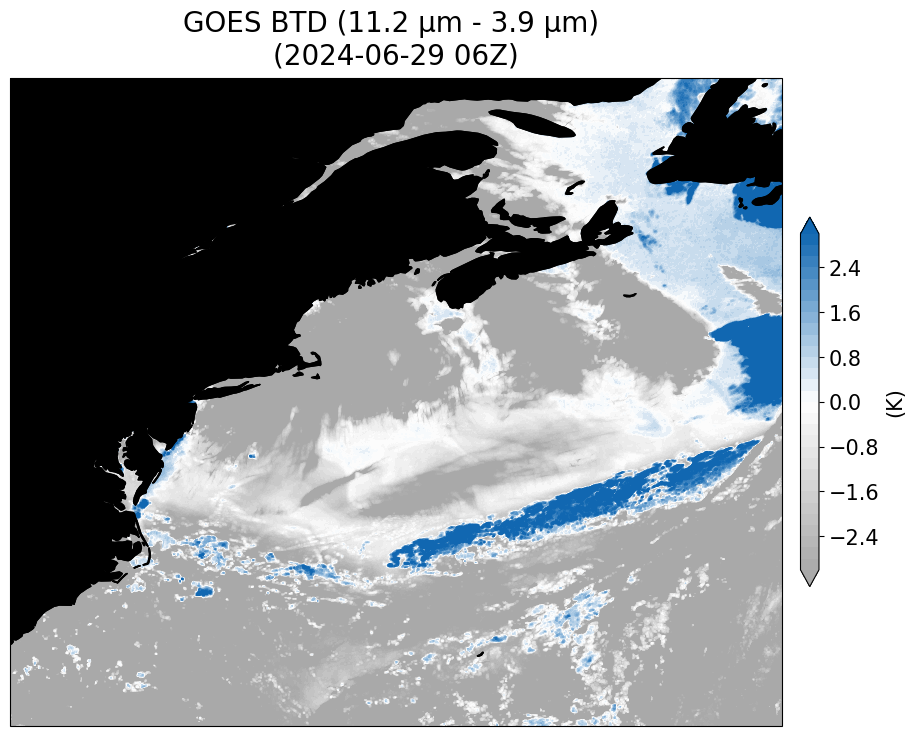

In [22]:
BTD = Tb_1 - Tb_2

projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---Custom colorbar
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, '#A9A9A9'), (0.5, 'white'), (1, '#1167b1')]  # +3 = blueish teal, 0 = white, -3 = grey
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

#---Optional: Set large negative to another color to try to identify overriding cirrus
#cmap.set_under('#DABC94')

levels = np.linspace(-3, 3, 31)

#---Optional: extend the colorbar
#levels = np.linspace(-6, 6, 31)

c=ax.contourf(BTD.lon, BTD.lat, BTD, cmap=cmap, extend='both', levels=levels)


clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

#--- Remove for global mapping
ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("GOES BTD ("+ str(wl_1) +" μm - " + str(wl_2) +" μm) \n("+datetime_str+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#000')

#fig.savefig("/Users/jesseturner/Downloads/satellite_btd_"+date_str, dpi=200, bbox_inches='tight')
fig.show()